# emission probability from acoustic ranges

imports

In [1]:
import io
import pathlib

import cf_xarray
import dask
import flox.xarray
import numpy as np
import pandas as pd
import xarray as xr

from pangeo_fish import utils
from pangeo_fish.acoustic import (
    count_detections,
    extract_receivers,
    search_acoustic_tag_id,
)
from pangeo_fish.healpy import (
    astronomic_to_cartesian,
    astronomic_to_cell_ids,
    buffer_points,
    geographic_to_astronomic,
)

xr.set_options(keep_attrs=True, display_expand_data=False)

parametrize with [papermill](https://papermill.readthedocs.io/en/latest/)

In [3]:
scheduler_address: str | None = None

tag_db_path: str
detections_path: str

receiver_buffer: float  # in [m]

emission_path: str
output_path: str

In [28]:
tag_url: str

catalog: str
catalog_parameters: dict = {}

scheduler_address: str | None = None

relative_depth_threshold: float = 0.8

diff_path: str

# local PC
tag_url="/Users/todaka/python/git/pangeo-fish/data_local/fish-intel/tag/nc/A18832.nc"
catalog = "https://data-taos.ifremer.fr/kerchunk/ref-copernicus.yaml"
scheduler_address: str | None = None
catalog = "https://data-taos.ifremer.fr/kerchunk/ref-marc.yaml"
diff_path="/Users/todaka/python/git/pangeo-fish/data_local/fish-intel/A18832-f1_e2500/diff.zarr"
tag_db_path= "/Users/todaka/python/git/pangeo-fish/data_local/fish-intel/acoustic/FishIntel_tagging_France.csv"
detections_path= "/Users/todaka/python/git/pangeo-fish/data_local/fish-intel/acoustic/detections_recaptured_fishintel.csv"

# mars
catalog = "/home/datawork-taos-s/intranet/kerchunk/ref-marc.yaml"
catalog_parameters: dict = {  "region": "f1_e2500",  "year": "2022"}
diff_path="/home/datawork-taos-s/public/fish/A18832-f1_e2500/diff.zarr"
diff_healpix_path="/home/datawork-taos-s/public/fish/A18832-f1_e2500/diff_healpix.zarr"

# Datarmor
tag_url="/home/datawork-lops-iaocea/data/fish-intel/tag/nc/A18832.nc"
# copernicus
catalog="/home/datawork-taos-s/intranet/kerchunk/ref-copernicus.yaml"
#catalog_parameters: dict = {  "type": ["2022_3D","2022_2D","mdt"]}
diff_path="/home/datawork-taos-s/public/fish/A18832-copernicus/diff.zarr"
diff_healpix_path="/home/datawork-taos-s/public/fish/A18832-copernicus/diff_healpix.zarr"
emission_path="/home/datawork-taos-s/public/fish/A18832-copernicus/emission.zarr"
tag_db_path="/home/datawork-lops-iaocea/data/fish-intel/acoustic/FishIntel_tagging_France.csv"
detections_path="/home/datawork-lops-iaocea/data/fish-intel/acoustic/detections_recaptured_fishintel.csv"
receiver_buffer= 1000.0
emission_acoustic_path="/home/datawork-taos-s/public/fish/A18832-copernicus/emission_acoustic.zarr"




create dask cluster

In [6]:
import dask_hpcconfig
from distributed import Client

In [7]:
cluster = dask_hpcconfig.cluster("datarmor-local")
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51586,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:53117,Total threads: 7
Dashboard: http://127.0.0.1:50546/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:58623,


## open data

tag database

In [11]:
tag_database = pd.read_csv(tag_db_path, sep=";")
tag_database.head(2)

,scientific_name,length,std_length,weight,capture_date,acoustic_tag_id,recaptured,pit_tag_number,dermYjet,scales,fin,recapture_longitude,recapture_latitude,recapture_date,recapture_method,fishing_gear
0,Dicentrarchus labrax,483,447.0,1002,12/06/2022,OPI-334,NaN,A18869,Y,Y,Y,NaN,NaN,NaN,NaN,NaN
1,Pollachius pollachius,572,NaN,1678,12/06/2022,OPI-488,NaN,A18876,Y,N,Y,NaN,NaN,NaN,NaN,NaN


detections

In [12]:
# work around the weird quoting
with open(detections_path, mode="r") as f:
    lines = (line.replace('"', "") for line in f)
    data = "\n".join(lines)
content = io.StringIO(data)

detection_database = (
    pd.read_csv(content, parse_dates=[1])
    .rename(columns={"date_time": "time"})
    .set_index("time")
)
detection_database.head(2)

,detection_id,tag_serial_number,acoustic_tag_id,animal_project_code,animal_id,scientific_name,acoustic_project_code,receiver_id,station_name,deploy_latitude,deploy_longitude,sensor_value,sensor_unit,sensor2_value,sensor2_unit,signal_to_noise_ratio,source_file,qc_flag,deployment_id
time,,,,,,,,,,,,,,,,,,,
2022-06-13 13:41:49,760464600,22060372,OPI-372,FISHINTEL,58594,Pollachius pollachius,FISHINTEL,TBR 800-002129,ancrage_mahuda,48.44993,-5.10307,NaN,NaN,NaN,NaN,35,20220620T140700Z_SN002129_0000000_0008000_003_...,NaN,28689
2022-06-13 13:44:47,760464613,22060372,OPI-372,FISHINTEL,58594,Pollachius pollachius,FISHINTEL,TBR 800-002129,ancrage_mahuda,48.44993,-5.10307,NaN,NaN,NaN,NaN,33,20220620T140700Z_SN002129_0000000_0008000_003_...,NaN,28689


base grid

In [13]:
ds = xr.open_dataset(emission_path, engine="zarr", chunks={"x": -1, "y": -1})
ds

<xarray.Dataset>
Dimensions:     (x: 527, y: 466, time: 1814)
Coordinates:
    cell_ids    (x, y) int64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    latitude    (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    longitude   (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    resolution  float64 ...
  * time        (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
Dimensions without coordinates: x, y
Data variables:
    final       (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    initial     (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    mask        (x, y) bool dask.array<chunksize=(527, 466), meta=np.ndarray>
    pdf         (time, x, y) float64 dask.array<chunksize=(1, 527, 466), meta=np.ndarray>
Attributes:
    max_sigma:  3.926612558378512
    nside:      4096
    rot_lat:    0
    rot_lon:    30
    tag_id:     A18832

## select detections

extract receiver locations

In [14]:
receivers = extract_receivers(detection_database).to_xarray()
receivers

<xarray.Dataset>
Dimensions:           (receiver_id: 8)
Coordinates:
  * receiver_id       (receiver_id) object 'TBR 800-002129' ... 'TBR 800 RELE...
Data variables:
    deploy_latitude   (receiver_id) float64 48.45 48.45 48.47 ... 48.88 48.53
    deploy_longitude  (receiver_id) float64 -5.103 -5.112 ... -3.464 -4.823
    station_name      (receiver_id) object 'ancrage_mahuda' ... 'basse_boureau'

In [15]:
acoustic_tag_id = search_acoustic_tag_id(tag_database, ds.attrs["tag_id"])
acoustic_tag_id

'OPI-511'

In [16]:
detections = (
    detection_database[["receiver_id", "acoustic_tag_id"]]
    .reset_index()
    .set_index("acoustic_tag_id")
    .loc[acoustic_tag_id]
    .set_index("time")
    .to_xarray()
)
detections

<xarray.Dataset>
Dimensions:      (time: 1903)
Coordinates:
  * time         (time) datetime64[ns] 2022-07-20T09:30:19 ... 2022-09-03T10:...
Data variables:
    receiver_id  (time) object 'TBR 800 RELEASE-002006' ... 'TBR 800 RELEASE-...

## detection weights

count detections

In [17]:
time_intervals = (
    ds[["time"]]
    .cf.add_bounds(keys="time")["time_bounds"]
    .pipe(cf_xarray.bounds_to_vertices, bounds_dim="bounds")
    .pipe(pd.IntervalIndex.from_breaks)
)
time_intervals

IntervalIndex([(2022-06-17 10:30:00, 2022-06-17 11:30:00], (2022-06-17 11:30:00, 2022-06-17 12:30:00], (2022-06-17 12:30:00, 2022-06-17 13:30:00], (2022-06-17 13:30:00, 2022-06-17 14:30:00], (2022-06-17 14:30:00, 2022-06-17 15:30:00] ... (2022-08-31 19:30:00, 2022-08-31 20:30:00], (2022-08-31 20:30:00, 2022-08-31 21:30:00], (2022-08-31 21:30:00, 2022-08-31 22:30:00], (2022-08-31 22:30:00, 2022-08-31 23:30:00], (2022-08-31 23:30:00, 2022-09-01 00:30:00]], dtype='interval[datetime64[ns], right]', length=1814)

In [18]:
weights = (
    count_detections(detections, by=time_intervals)
    .swap_dims({"time_bins": "time"})
    .assign_coords(time=ds.time)
    .pipe(lambda ds: ds.merge(receivers.sel(receiver_id=ds["receiver_id"])))
    .pipe(utils.normalize, dim="receiver_id")
    .fillna(0)
    .rename_vars({"count": "weights"})["weights"]
)
weights

<xarray.DataArray 'weights' (receiver_id: 2, time: 1814)>
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0
Coordinates:
  * receiver_id  (receiver_id) object 'TBR 800 RELEASE-002006' 'TBR 800 RELEA...
    time_bins    (time) object (2022-06-17 10:30:00, 2022-06-17 11:30:00] ......
    resolution   float64 0.0002498
  * time         (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01

## detection maps

The stations have a detection range given by `receiver_buffers`. For the maps, we select all pixels within that range and set those to `1`.

In [19]:
rot = {k.removeprefix("rot_"): v for k, v in ds.attrs.items() if k.startswith("rot_")}
phi, theta = geographic_to_astronomic(
    lon=receivers.deploy_longitude, lat=receivers.deploy_latitude, rot=rot
)
cartesian_positions = astronomic_to_cartesian(theta=theta, phi=phi, dim="receiver_id")
cartesian_positions

<xarray.DataArray 'deploy_longitude' (receiver_id: 8, cartesian: 3)>
0.4304 0.3814 0.8181 0.4304 0.3815 0.818 ... 0.3627 0.8342 0.4279 0.3782 0.8209
Coordinates:
  * receiver_id  (receiver_id) object 'TBR 800-002129' ... 'TBR 800 RELEASE-0...
  * cartesian    (cartesian) <U1 'x' 'y' 'z'

Unfortunately, the cell ids stored as a coordinate are not the correct ones, so we have to reconstruct the correct ones.

In [20]:
phi, theta = geographic_to_astronomic(lat=ds.latitude, lon=ds.longitude, rot=rot)
cell_ids = astronomic_to_cell_ids(nside=ds.attrs["nside"], phi=phi, theta=theta)
cell_ids

<xarray.DataArray 'longitude' (x: 527, y: 466)>
13016638 13016724 13016726 13016733 ... 13338577 13338582 13338588 13338591
Coordinates:
    cell_ids    (x, y) int64 9876645 9876647 9876653 ... 13277089 13277091
    latitude    (x, y) float64 42.41 42.42 42.44 42.45 ... 54.5 54.51 54.52
    longitude   (x, y) float64 -5.295 -5.282 -5.268 ... -3.084 -3.066 -3.047
    resolution  float64 0.0002498
Dimensions without coordinates: x, y
Attributes:
    units:    deg

In [21]:
masks = buffer_points(
    cell_ids,
    cartesian_positions,
    nside=ds.attrs["nside"],
    buffer_size=receiver_buffer,
    factor=2**16,
    intersect=True,
)
masks

<xarray.DataArray 'longitude' (receiver_id: 8, x: 527, y: 466)>
False False False False False False ... False False False False False False
Coordinates:
    cell_ids     (x, y) int64 13016638 13016724 13016726 ... 13338588 13338591
    latitude     (x, y) float64 42.41 42.42 42.44 42.45 ... 54.5 54.51 54.52
    longitude    (x, y) float64 -5.295 -5.282 -5.268 ... -3.084 -3.066 -3.047
    resolution   float64 0.0002498
  * receiver_id  (receiver_id) object 'TBR 800-002129' ... 'TBR 800 RELEASE-0...
Dimensions without coordinates: x, y
Attributes:
    units:    deg

In [22]:
combined_mask = masks.sum(dim="receiver_id").astype(bool)
combined_mask

<xarray.DataArray 'longitude' (x: 527, y: 466)>
False False False False False False ... False False False False False False
Coordinates:
    cell_ids    (x, y) int64 13016638 13016724 13016726 ... 13338588 13338591
    latitude    (x, y) float64 42.41 42.42 42.44 42.45 ... 54.5 54.51 54.52
    longitude   (x, y) float64 -5.295 -5.282 -5.268 ... -3.084 -3.066 -3.047
    resolution  float64 0.0002498
Dimensions without coordinates: x, y
Attributes:
    units:    deg

In [23]:
grid = ds.cf[["latitude", "longitude"]]
grid

<xarray.Dataset>
Dimensions:    (x: 527, y: 466)
Dimensions without coordinates: x, y
Data variables:
    latitude   (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    longitude  (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
Attributes:
    max_sigma:  3.926612558378512
    nside:      4096
    rot_lat:    0
    rot_lon:    30
    tag_id:     A18832

## apply weights

In [24]:
reindexed = weights.reindex(time=ds.time, fill_value=0).chunk({"time": 1})
reindexed

<xarray.DataArray 'weights' (receiver_id: 2, time: 1814)>
dask.array<chunksize=(2, 1), meta=np.ndarray>
Coordinates:
  * receiver_id  (receiver_id) object 'TBR 800 RELEASE-002006' 'TBR 800 RELEA...
    time_bins    (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    resolution   float64 0.0002498
  * time         (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01

In [25]:
fill_values = reindexed.sum(dim="receiver_id").pipe(lambda ds: 1 - ds)
fill_values

<xarray.DataArray 'weights' (time: 1814)>
dask.array<chunksize=(1,), meta=np.ndarray>
Coordinates:
    time_bins   (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    resolution  float64 0.0002498
  * time        (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01

In [26]:
acoustic_pdfs = (
    (reindexed * masks.astype(float))
    .sum(dim="receiver_id")
    .where(combined_mask, fill_values)
    .chunk()
)
acoustic_pdfs

<xarray.DataArray (time: 1814, x: 527, y: 466)>
dask.array<chunksize=(1, 527, 466), meta=np.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
    time_bins   (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    resolution  float64 0.0002498
    cell_ids    (x, y) int64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    latitude    (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    longitude   (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
Dimensions without coordinates: x, y

## assign and store to disk

In [27]:
combined = ds.assign(acoustic=acoustic_pdfs)
combined

<xarray.Dataset>
Dimensions:     (x: 527, y: 466, time: 1814)
Coordinates:
    cell_ids    (x, y) int64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    latitude    (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    longitude   (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    resolution  float64 ...
  * time        (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
    time_bins   (time) object dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    final       (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    initial     (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    mask        (x, y) bool dask.array<chunksize=(527, 466), meta=np.ndarray>
    pdf         (time, x, y) float64 dask.array<chunksize=(1, 527, 466), meta=np.ndarray>
    acoustic    (time, x, y) float64 dask.array<chunksize=(1, 527, 466), meta=np.ndarray>
Attributes:
    max_sigma:  3.926612558378512
    nside:      4096
    rot_lat:    0
    rot_lon:    30
    tag_id:     A18832

write to disk

In [29]:
%%time
combined.drop_vars(["time_bins"]).to_zarr(emission_acoustic_path, mode="w", consolidated=True)

In [30]:
emission_=xr.open_zarr(emission_acoustic_path)
emission_

<xarray.Dataset>
Dimensions:     (time: 1814, x: 527, y: 466)
Coordinates:
    cell_ids    (x, y) int64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    latitude    (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    longitude   (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    resolution  float64 ...
  * time        (time) datetime64[ns] 2022-06-17T11:00:00 ... 2022-09-01
Dimensions without coordinates: x, y
Data variables:
    acoustic    (time, x, y) float64 dask.array<chunksize=(1, 527, 466), meta=np.ndarray>
    final       (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    initial     (x, y) float64 dask.array<chunksize=(527, 466), meta=np.ndarray>
    mask        (x, y) bool dask.array<chunksize=(527, 466), meta=np.ndarray>
    pdf         (time, x, y) float64 dask.array<chunksize=(1, 527, 466), meta=np.ndarray>
Attributes:
    max_sigma:  3.926612558378512
    nside:      4096
    rot_lat:    0
    rot_lon:    30
    tag_id:     A18832

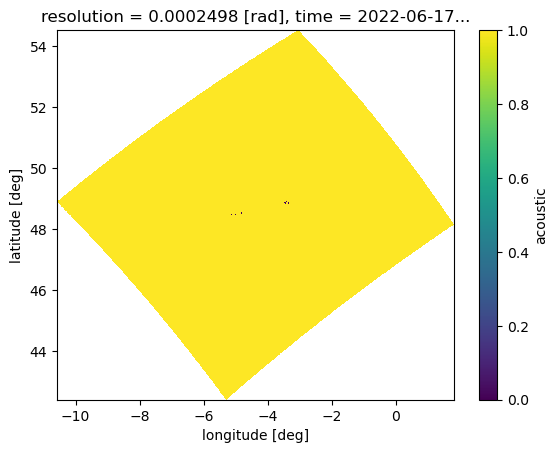

In [31]:
emission_.acoustic.isel(time=0).plot(x='longitude',y='latitude')

## visualization